<a href="https://colab.research.google.com/github/drug173/Fasads/blob/main/Fasads_windows_mask_count_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#   СЕГМЕНТАЦИЯ ФАСАДОВ ЗДАНИЙ 
#### Сегментация фасадов с применением нейронных сетей

### Готовые решения применений  нейронных сетей в сфере недвижимости

###1)  The bedroom script - проект  John Porral, программе задают контур жилья, она создаѐт варианты планировок.  Планировки объединяются в  квартиры и жилые дома.

###2) Проект Spacemaker от компании Autodesk - облачный софт, для генерации квартир. Компания Autodesk приостановила свою деятельность в России (воспользоваться нельзя).

###3) Архитектор Abhinav Mishra натренировал нейронные сети генерировать планы и фасады соборов.

###4)  The Meters - сервис по поиску недвижимости для покупки и аренды

###5) 

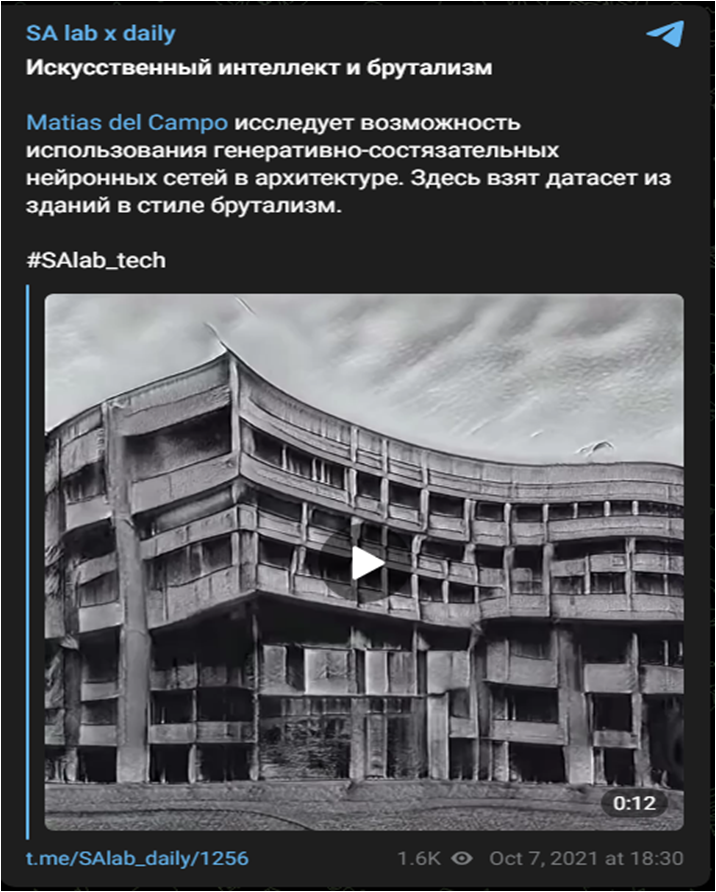


### 6) Решение по сегментации фасадов в GitHub

https://github.com/prttyflvck0/Unet-Segmentation-with-Tensorflow

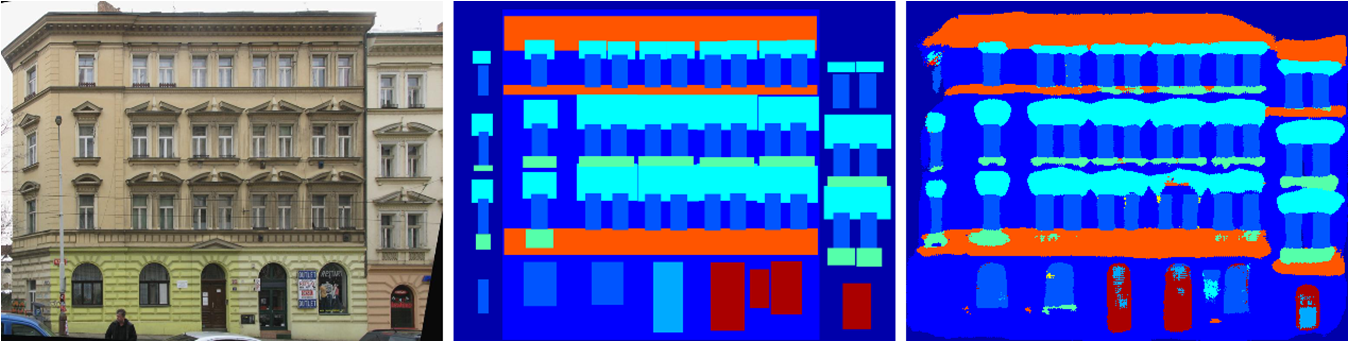

### Для решения задачи сегментации фасада здания (выделения сегментов окон) и подсчёта количества окон необходимо:

1)  Собрать датасет фасадов зданий с размеченными сегментами окон.

2)  Построить модель нейронной сети для сегментации фасада.

3)  Натренировать модель сети.

4)  Проверить работоспособность модели на тестовых данных.

5)  Разработать функцию подсчёта окон на фасаде.


## 1) Датасет

### Датасет был взят с Kaggle   https://www.kaggle.com/datasets/adlteam/facade-dataset

                                 
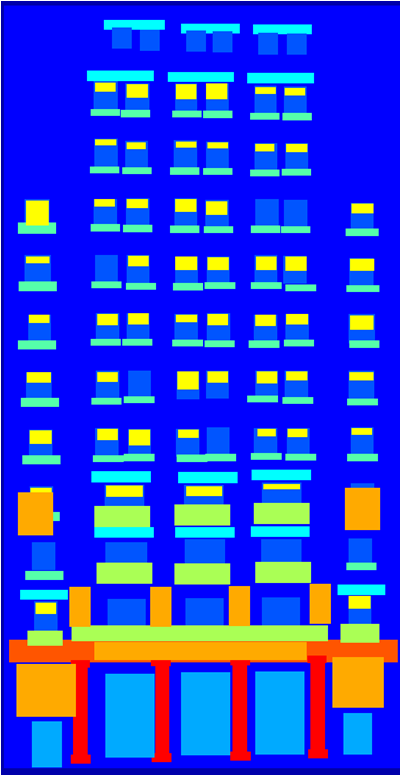  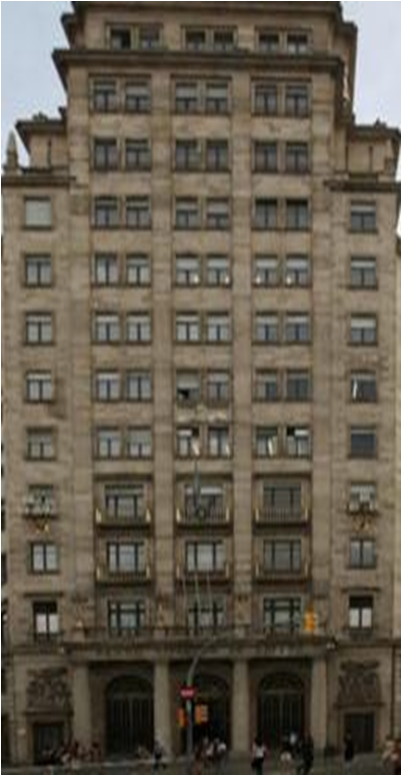


                                                                                                



#### Данный датасет имеет разметку дверей, окон, балконов и прочих элементов фасада. Из данных изображений масок фасадов необходимо убрать лишние элементы, и привести изображение к бинарному виду, также изменим размеры всех изображений (чтобы все изображения были одного размера).

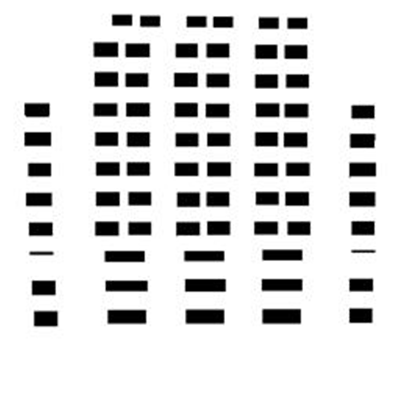  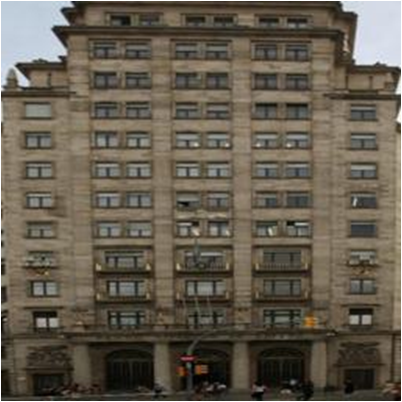 

# Решение

In [62]:
import torch
torch.cuda.empty_cache()  

### Параметры модели

In [63]:
CLASSES = ['window', 'backgound']
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' 
#DEVICE = 'cuda'
#DEVICE = 'cpu'
BATCH_SIZE = 10
EPOCHS = 30
x_size = 256
y_size = 256

### Загрузка данных

In [64]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!ls /content/gdrive/"My Drive"

Mounted at /content/gdrive
'Colab Notebooks'   Files


In [65]:
!cp /content/gdrive/'My Drive'/Files/data.zip .
!unzip data.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: DataSet/data3/train/mask/4605.jpg  
  inflating: DataSet/data3/train/mask/4606.jpg  
  inflating: DataSet/data3/train/mask/4607.jpg  
  inflating: DataSet/data3/train/mask/4608.jpg  
  inflating: DataSet/data3/train/mask/4609.jpg  
  inflating: DataSet/data3/train/mask/4610.jpg  
  inflating: DataSet/data3/train/mask/4611.jpg  
  inflating: DataSet/data3/train/mask/4612.jpg  
  inflating: DataSet/data3/train/mask/4613.jpg  
  inflating: DataSet/data3/train/mask/4614.jpg  
  inflating: DataSet/data3/train/mask/4615.jpg  
  inflating: DataSet/data3/train/mask/4616.jpg  
  inflating: DataSet/data3/train/mask/4617.jpg  
  inflating: DataSet/data3/train/mask/4618.jpg  
  inflating: DataSet/data3/train/mask/4619.jpg  
  inflating: DataSet/data3/train/mask/4620.jpg  
  inflating: DataSet/data3/train/mask/4621.jpg  
  inflating: DataSet/data3/train/mask/4622.jpg  
  inflating: DataSet/data3/train/mask/4623.jpg  
 

In [66]:
!cp /content/gdrive/'My Drive'/Files/label_class_dict.csv .

In [67]:
!cp /content/gdrive/'My Drive'/Files/best_model_4.pth .
!cp /content/gdrive/'My Drive'/Files/best_model_3.pth .


### Установка библиотек

In [68]:



!pip install albumentations==0.4.3

!pip install segmentation-models-pytorch==0.1.0

!pip install ttach==0.0.2

!pip install tensorflow


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###  Импорты библиотек


In [69]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

import albumentations as albu

import torch
import numpy as np
import segmentation_models_pytorch as smp
from glob import glob
from PIL import Image
from torchsummary import summary

print(torch.cuda.is_available())

True


### Проверка подключения GPU

In [70]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")


### Пути к данным

In [71]:
DATA_DIR = './DataSet/data3/'


In [72]:
path_csv = os.path.join('./label_class_dict.csv')

path_model_best = os.path.join('./best_model_2.pth')



x_train_dir = os.path.join(DATA_DIR, 'train/image/')
y_train_dir = os.path.join(DATA_DIR, 'train/mask/')

x_valid_dir = os.path.join(DATA_DIR, 'val/image/')
y_valid_dir = os.path.join(DATA_DIR, 'val/mask/')

x_test_dir = os.path.join(DATA_DIR, 'test/image/')
y_test_dir = os.path.join(DATA_DIR, 'test/mask/')

### Функции просмотра изображений и масок

In [73]:
# Просмотр изображений
# вывод несколько изображений 
def display(**images):
    
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()


# Вывод изображения, оригинальной маски и предсказанной маски
def display_img(img, mask, pred):
    mask = mask.transpose(1, 2, 0).astype('float32')
    mask = mask[:,:,0]
    #img = np.reshape(img,(256,256,3))
    #mask = np.reshape(mask,(256,256,3))
    #pred = np.reshape(pred,(256,256,1))
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,10))
    ax1.imshow(img)
    ax1.axis('off')
    ax2.imshow(mask,  cmap="gray")
    ax2.axis('off')
    ax3.imshow(pred,  cmap="gray")
    ax3.axis('off')

# Функции просмотра изображений и маски
def display_img_mask(img, mask):

    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
    ax1.imshow(img)
    ax1.axis('off')
    ax2.imshow(mask,  cmap="gray")
    ax2.axis('off')
 
# Функции просмотра изображений
def display_img_mask_newMask(img, mask, new_mask):

    fig,(ax1,ax2, ax3) = plt.subplots(1,3,figsize=(15,10))
    ax1.imshow(img)
    ax1.axis('off')
    ax2.imshow(mask,  cmap="gray")
    ax2.axis('off')
    ax3.imshow(new_mask,  cmap="gray")
    ax3.axis('on')



def display_mask(img):
  fig, ax = plt.subplots()
  ax.imshow(img,  cmap="gray")
  fig.set_figwidth(6)    #  ширина и
  fig.set_figheight(6)    #  высота "Figure"
  plt.show()    

### DataSet


In [74]:
class Dataset(BaseDataset):
    """
    
    images_dir: Путь к папке с изображениями

    masks_dir: Путь к папке с масками
    
    """
    CLASSES = ['window', 'backgound']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask1 = cv2.imread(self.masks_fps[i], cv2.IMREAD_GRAYSCALE)
        ret, mask = cv2.threshold(mask1, 127, 255, cv2.THRESH_BINARY)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

#### просмотр   изображения и маски

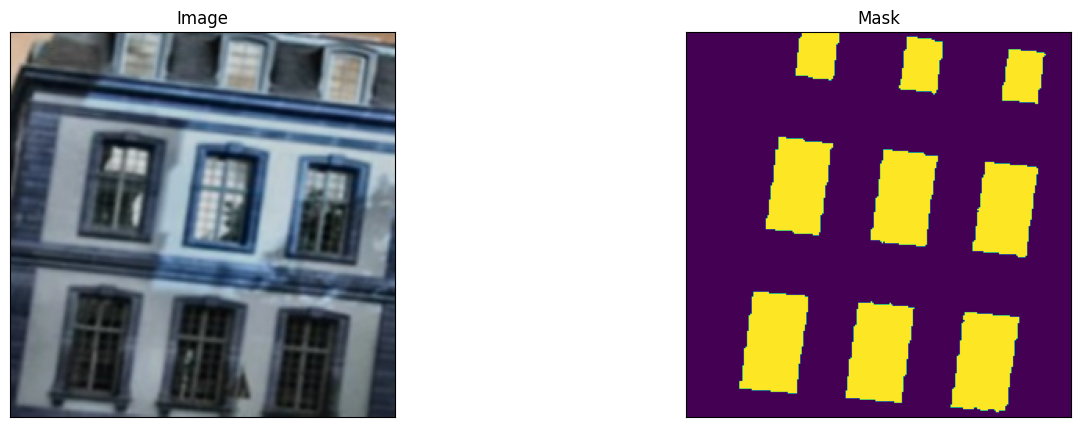

In [75]:
dataset = Dataset(x_train_dir, y_train_dir, classes=['window'])
#dataset = Dataset(x_train_dir, y_train_dir)
image, mask = dataset[0] 

display(
    image=image, 
    mask=mask,
)

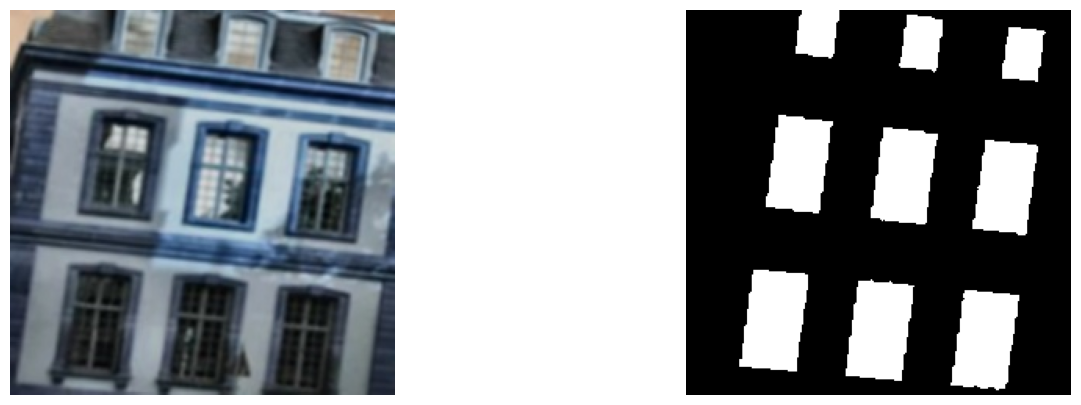

In [76]:
display_img_mask(image, mask.squeeze())

### Аугментация


In [77]:
def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        albu.PadIfNeeded(min_height=y_size, min_width=x_size, always_apply=True, border_mode=0),
        albu.RandomCrop(height=y_size, width=x_size, always_apply=True),
        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),
        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [
        albu.PadIfNeeded(y_size, x_size)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

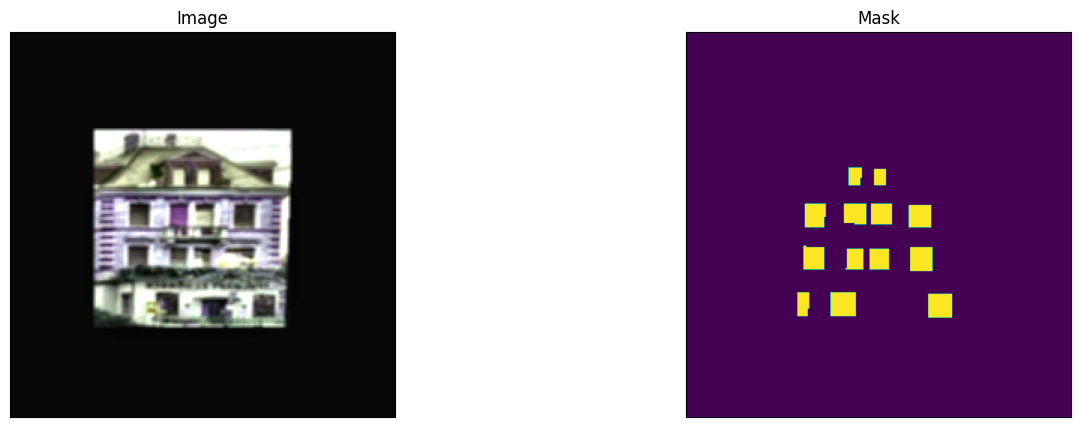

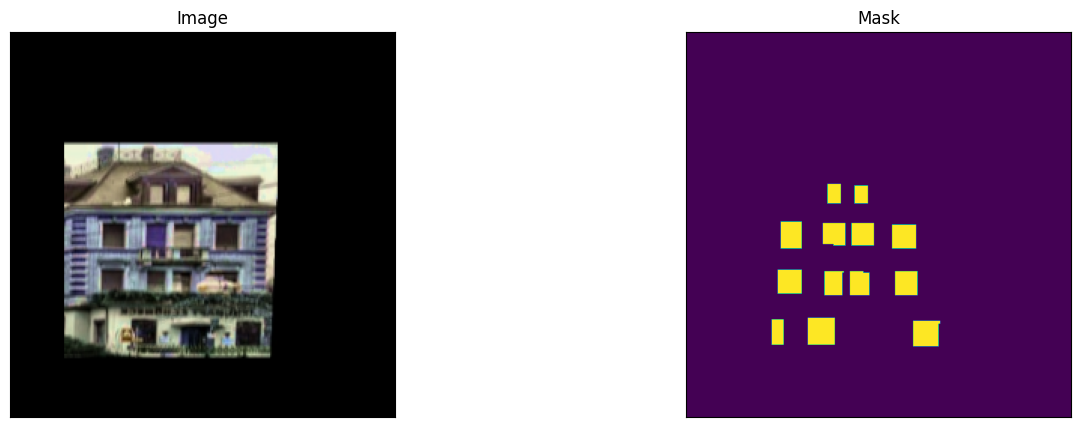

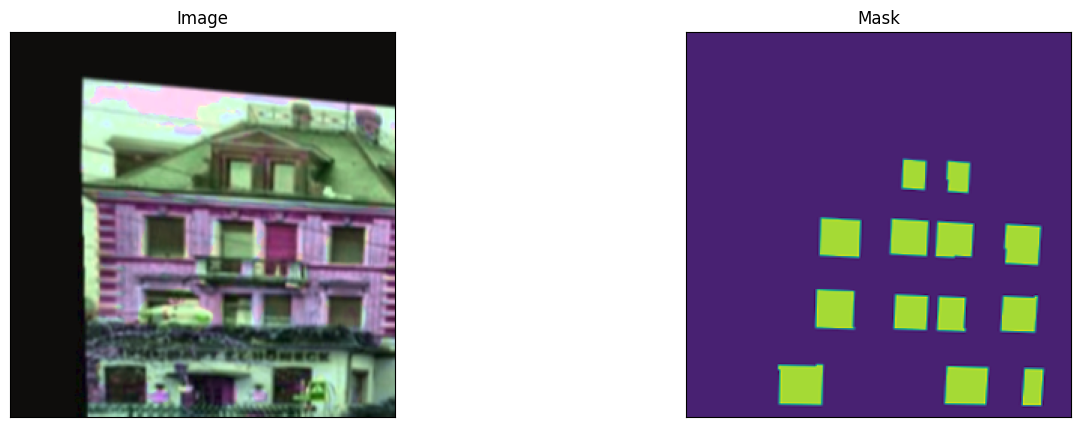

In [78]:
# Просмотр применения аугментации

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['window'],
)


for i in range(3):
    image, mask = augmented_dataset[5]
    display(image=image, mask=mask.squeeze(-1))

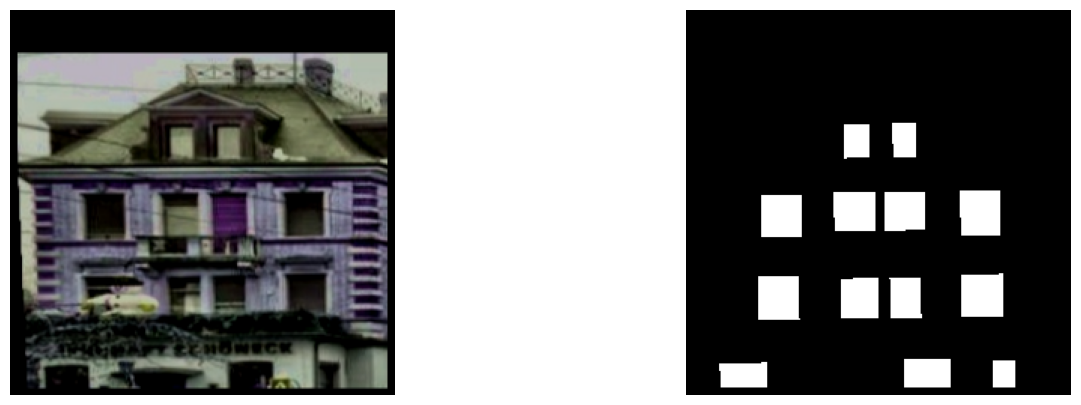

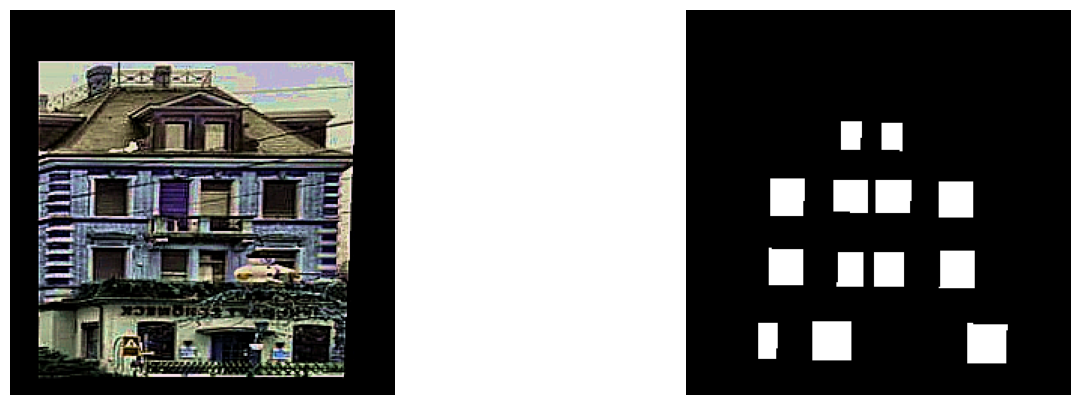

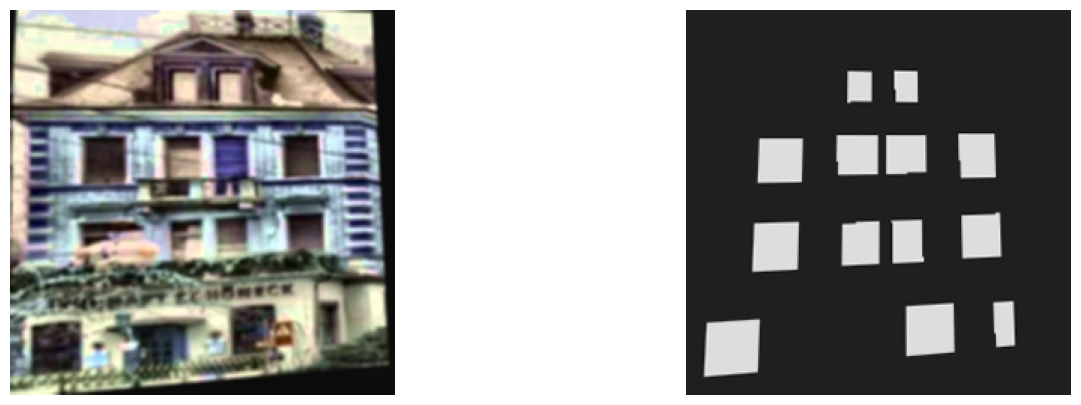

In [79]:
for i in range(3):
    image, mask = augmented_dataset[5]
    display_img_mask(image, mask=mask.squeeze(-1))



## Модель

In [80]:
#
#   Создаём модель
#
#   Энкодер - resnet50
#
#   Предобученные веса -  imagenet
#

model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)



In [81]:
# ЗАГРУЗКА МОДЕЛИ (Ранее сохранённой натренированной модели)
model = torch.load('./best_model_5.pth', map_location=torch.device(DEVICE))

In [82]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

фомируем датасеты

In [83]:


# тренировачный датасет
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

# проверочный датасет
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)



In [84]:
# Загрузка датасетов
train_loader = DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle=True, num_workers=1)
valid_loader = DataLoader(valid_dataset, batch_size= BATCH_SIZE, shuffle=False, num_workers=1)

In [85]:

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [86]:

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

#### просмотр модели

In [87]:
print(model)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [88]:

summary(model,(3, 256, 256) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

## Тренировка модели

In [89]:
# ТРЕНИРОВКА МОДЕЛИ

max_score = 0
logs_v_loss = []
logs_v_iou = []
logs_t_loss = []
logs_t_iou = []
steps = []
EPOCHS = 44

for i in range(0, EPOCHS):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    logs_v_loss.append(valid_logs['dice_loss'])
    logs_v_iou.append(valid_logs['iou_score'])
    logs_t_loss.append(train_logs['dice_loss'])
    logs_t_iou.append(train_logs['iou_score'])
    steps.append(i)
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model_5.pth')
        print('Model saved!')
        
    if i % 20 == 0:
        optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr']/2
        print('Изменение - learning rate: ', optimizer.param_groups[0]['lr'])


Epoch: 0
valid: 100%|██████████| 101/101 [00:08<00:00, 12.50it/s, dice_loss - 0.163, iou_score - 0.7207]
Model saved!
Изменение - learning rate:  5e-05

Epoch: 1
valid: 100%|██████████| 101/101 [00:07<00:00, 12.94it/s, dice_loss - 0.1603, iou_score - 0.7246]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:07<00:00, 13.02it/s, dice_loss - 0.1582, iou_score - 0.7277]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:08<00:00, 12.54it/s, dice_loss - 0.1566, iou_score - 0.7301]
Model saved!

Epoch: 4
valid: 100%|██████████| 101/101 [00:08<00:00, 11.98it/s, dice_loss - 0.1569, iou_score - 0.7297]

Epoch: 5
valid: 100%|██████████| 101/101 [00:08<00:00, 11.57it/s, dice_loss - 0.1566, iou_score - 0.73]

Epoch: 6
valid: 100%|██████████| 101/101 [00:08<00:00, 11.54it/s, dice_loss - 0.1548, iou_score - 0.7328]
Model saved!

Epoch: 7
valid: 100%|██████████| 101/101 [00:08<00:00, 11.67it/s, dice_loss - 0.1548, iou_score - 0.7328]
Model saved!

Epoch: 8
valid: 100%|██████████| 1

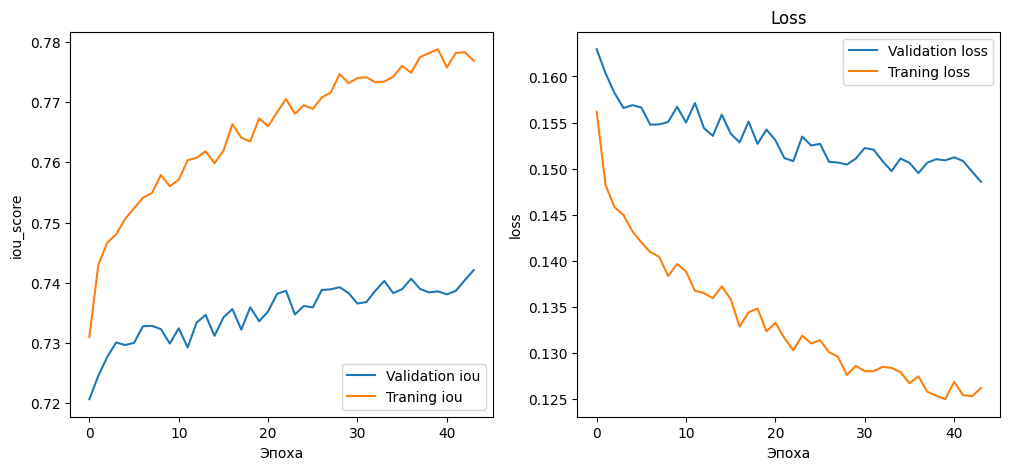

In [108]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(steps, logs_v_iou, label='Validation iou')
plt.plot(steps, logs_t_iou, label='Traning iou')
plt.xlabel("Эпоха")
plt.ylabel("iou_score")
plt.legend(loc='lower right')
plt.title("")

plt.subplot(1, 2, 2)
plt.plot(steps, logs_v_loss, label='Validation loss')
plt.plot(steps, logs_t_loss, label='Traning loss')
plt.xlabel("Эпоха")
plt.ylabel("loss")
plt.legend(loc='upper right')
plt.title("Loss")


plt.show()

## ПРОВЕРКА НА ТЕСТОВОМ НАБОРЕ


In [109]:
# ЗАГРУЗКА МОДЕЛИ
model = torch.load('./best_model_5.pth', map_location=torch.device(DEVICE))

In [110]:
# формирование тестового датасета
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir,
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

# Загрузка тестового датасета
test_dataloader = DataLoader(test_dataset)

In [111]:
# Оценка модели тестовым набором
test_epoch = smp.utils.train.ValidEpoch(
    model=model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 251/251 [00:04<00:00, 59.23it/s, dice_loss - 0.1099, iou_score - 0.8064]


###  Просмотр предсказанных изображений

In [112]:
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)


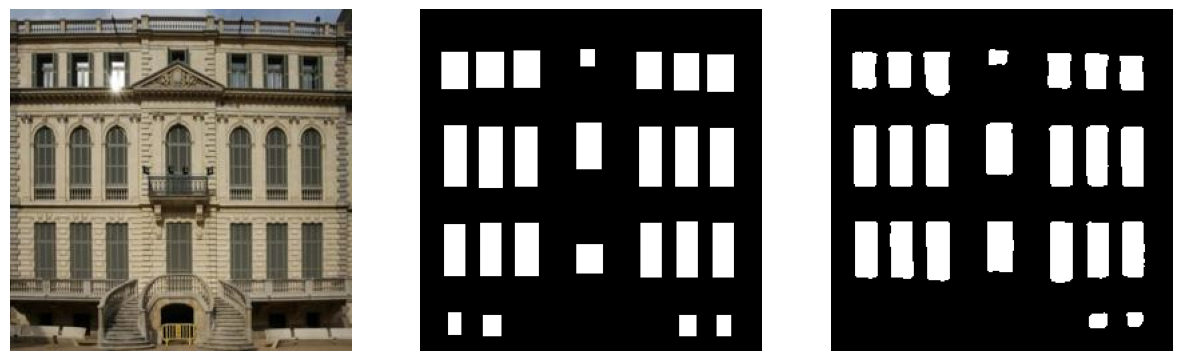

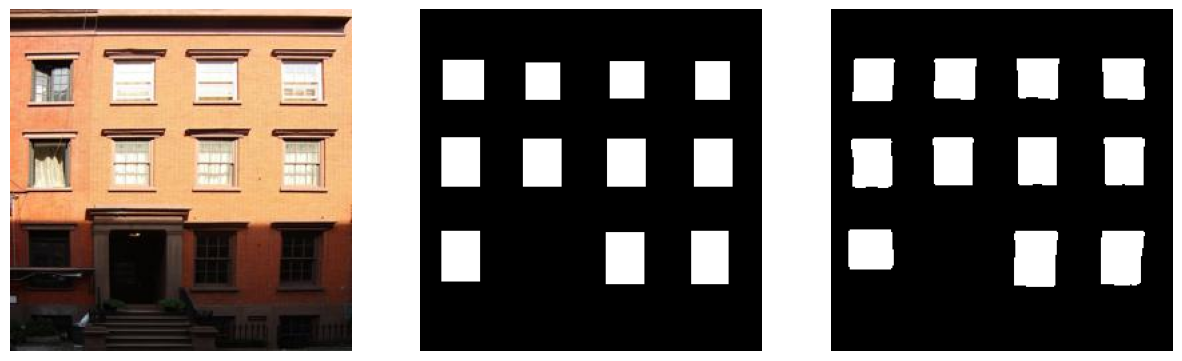

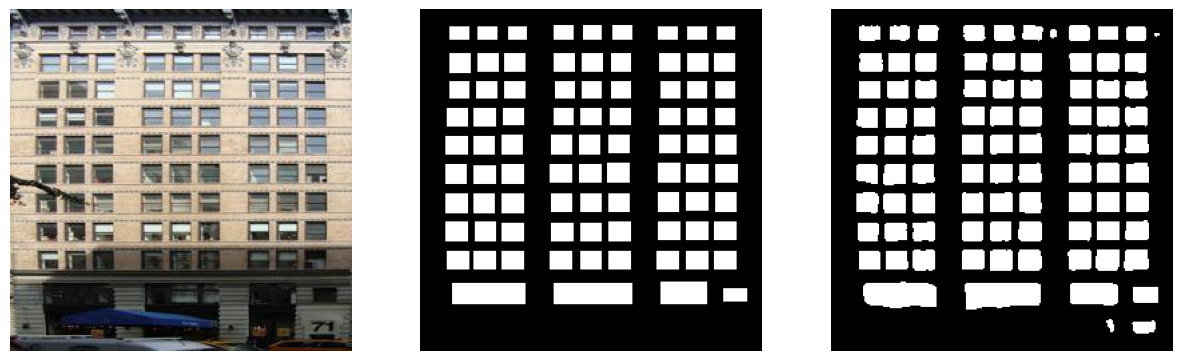

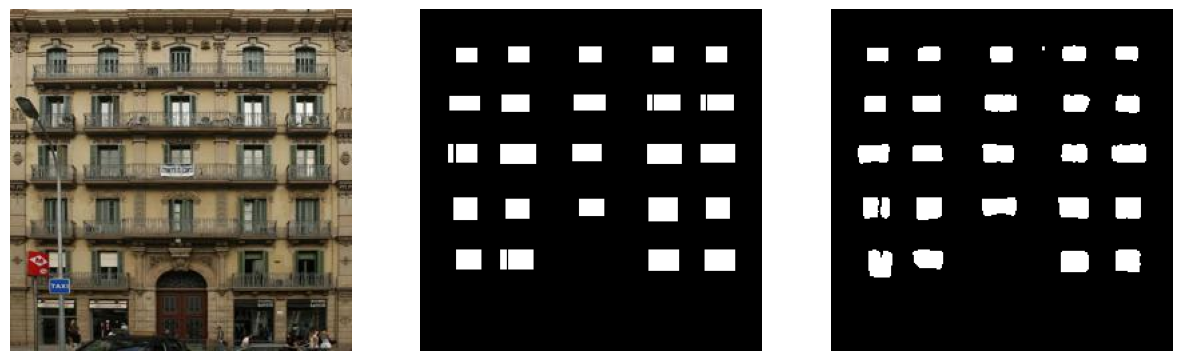

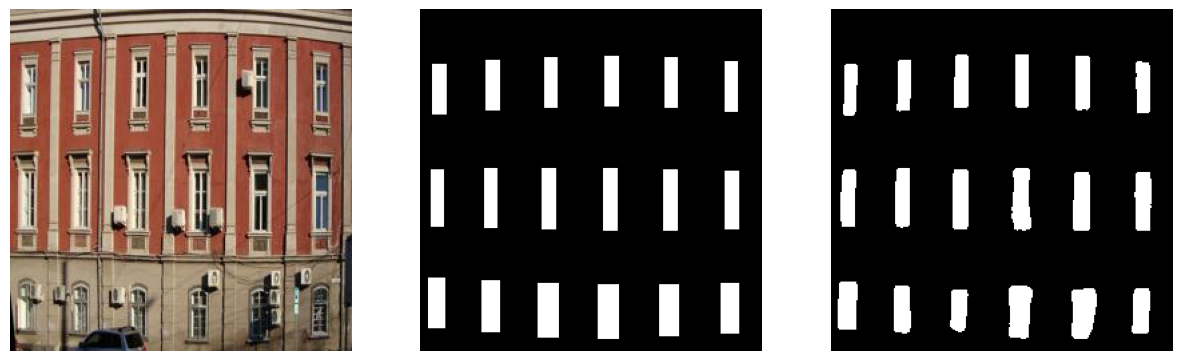

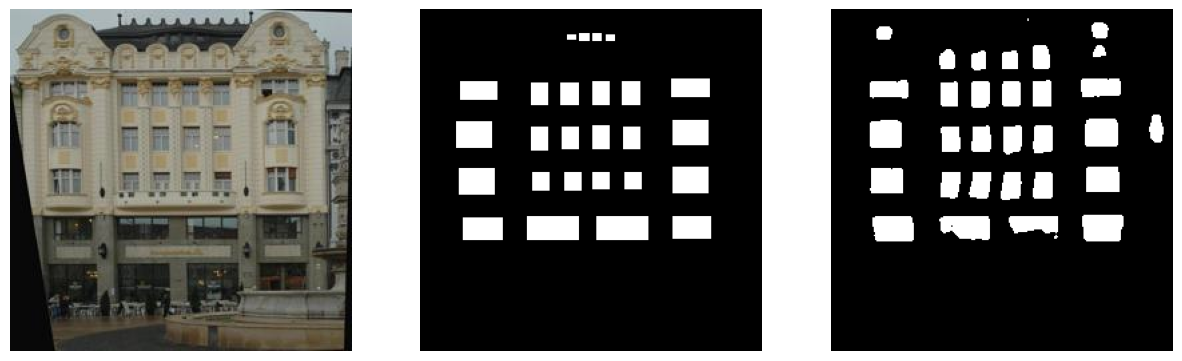

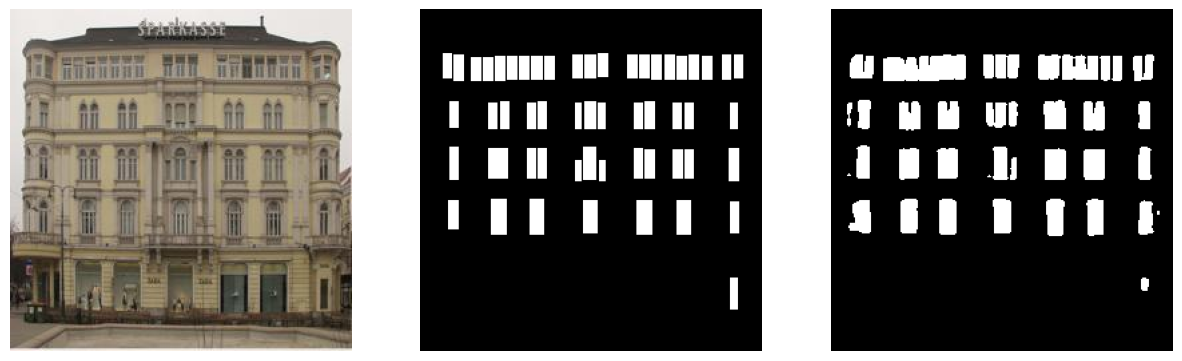

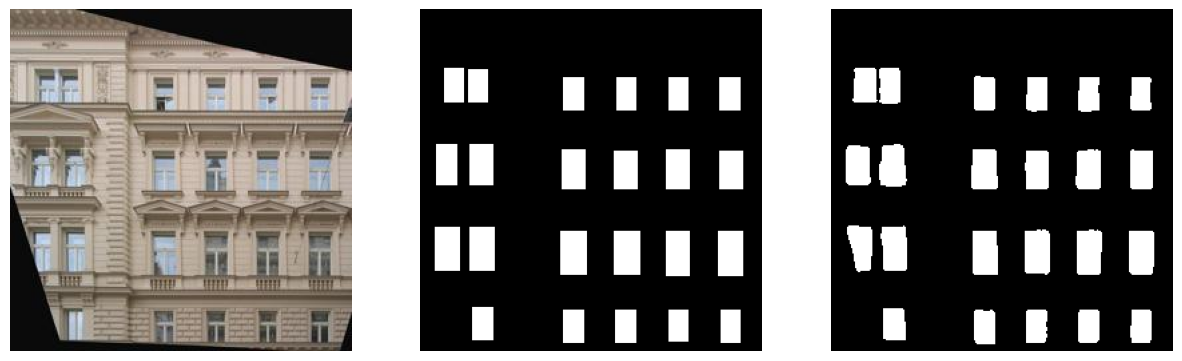

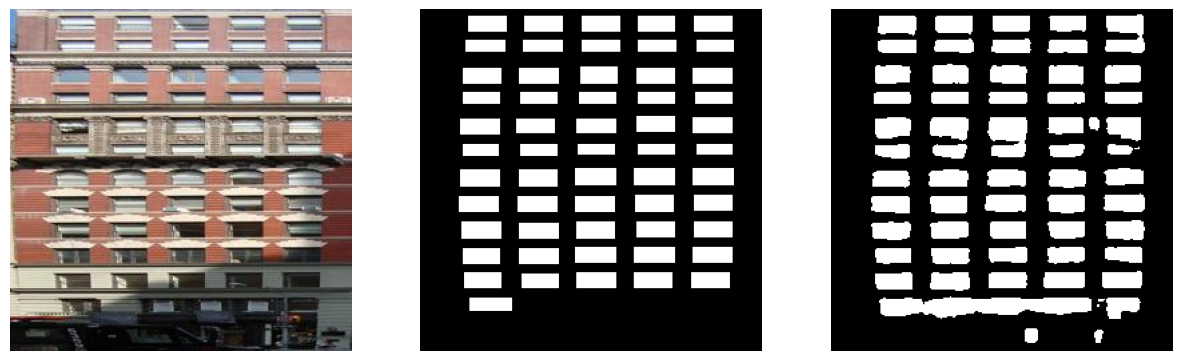

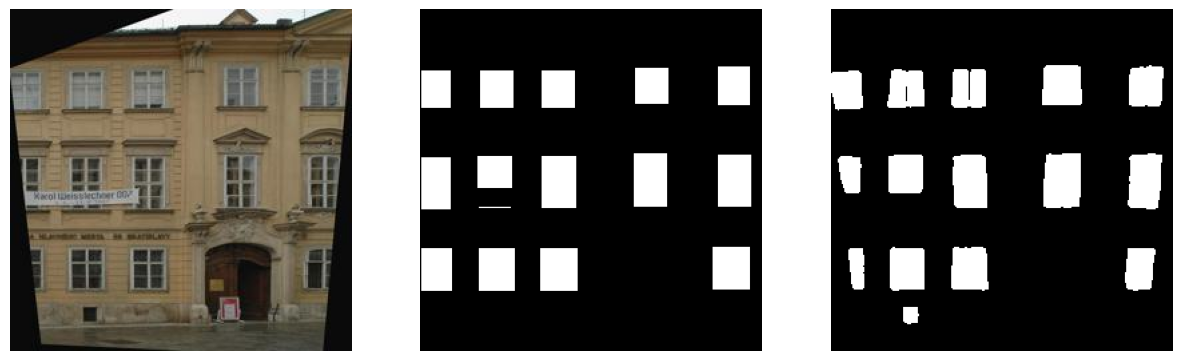

In [113]:
for i in range(10):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())

    display_img(image_vis, gt_mask, pr_mask )  



## ПОДСЧЁТ КОЛИЧЕСТВА ОКОН

#### Вспомогательные функции для подсчёта окон

In [114]:
# функция проверяет принадлежит ли точка ранее найденному окну?
def belong(x, y, set_point: list):
    if (set_point[0] <= x <= set_point[2]) and (set_point[1] <= y <= set_point[3]):
        return True
    else:
        return False
                        

In [115]:
# Поиск всех точек принадлежащих новому окну
def search_points(a, b, img5):
    img = img5
    # list_points_window = [0, 0, 0, 0]  # Список содержащий угловые точки окна
    x0 = a   # точка начала движения
    y0 = b
    
    y1 = b    # текущий номер верхней строки окна
    x1 = a    # текущий номер левого столбца окна
    y2 = b    # текущий номер нижней строки окна
    x2 = a    # текущий номер правого столбца окна
    
    x = a     #  текущее положение точки
    y = b
    
    mov = 'RIGHT'   #   направление движения (начинаем движение вправо)
    flag_round = False
    
    while flag_round == False:  # Пока не вернулись в исходную точку, обходим точки окна          
        if mov == 'NONE': # Если единственный пиксель чёрный
            continue
        if mov == 'RIGHT': # движемся вправо
            list1 = right_mov(x, y, img)  # выбираем новую точку и направление движения
            xx = list1[0] 
            if x1 > list1[0]:
                x1 = list1[0]
            if x2 < list1[0]:
                x2 = list1[0]
            if y1 > list1[1]:
                y1 = list1[1]
            if y2 < list1[1]:
                y2 = list1[1]
            x = list1[0]
            y = list1[1]
            mov = list1[2]
            flag_round =( x0 == x and y0 == y)
            continue          

        if mov == 'LEFT': # движемся влево
            list1 = left_mov(x, y, img)  # выбираем новую точку и направление движения  
            if x1 > list1[0]:
                x1 = list1[0]
            if x2 < list1[0]:
                x2 = list1[0]
            if y1 > list1[1]:
                y1 = list1[1]
            if y2 < list1[1]:
                y2 = list1[1]
            x = list1[0]
            y = list1[1]
            mov = list1[2]
            flag_round =( x0 == x and y0 == y)
            continue
                        
        if mov == 'DOWN': # движемся вниз
            list1 = down_mov(x, y, img)  # выбираем новую точку и направление движения 
         
            if x1 > list1[0]:
                x1 = list1[0]
            if x2 < list1[0]:
                x2 = list1[0]
            if y1 > list1[1]:
                y1 = list1[1]
            if y2 < list1[1]:
                y2 = list1[1]
            x = list1[0]
            y = list1[1]
            mov = list1[2]
            flag_round =( x0 == x and y0 == y)
            continue     

        if mov == 'UP': # движемся вверх
            list1 = up_mov(x, y, img)  # выбираем новую точку и направление движения
            if x1 > list1[0]:
                x1 = list1[0]
            if x2 < list1[0]:
                x2 = list1[0]
            if y1 > list1[1]:
                y1 = list1[1]
            if y2 < list1[1]:
                y2 = list1[1]
            x = list1[0]
            y = list1[1]
            mov = list1[2]
            flag_round =( x0 == x and y0 == y)
            continue  
            
    list_points_window = [x1, y1, x2, y2] 

    vv = 0
    return  list_points_window    


In [116]:
# функция движения вправо
def right_mov(x, y, img):  #  Выбираем направление  продолжения движения
    size = 255
    if y  > 0 and img[x, y - 1] == 0:
        mov = 'UP'
        y = y - 1
        return [x, y, mov]
    if x < size and img[x + 1, y] == 0:
        mov = 'RIGHT'
        x = x + 1
        return [x, y, mov]  
    if y < size and img[x, y + 1] == 0:
        mov = 'DOWN'
        y = y + 1
        return [x, y, mov]    
    if x > 0 and img[x - 1, y] == 0:
        mov = 'LEFT'
        x = x - 1
        return [x, y, mov]
    else:
        mov = 'NONE'
        return [x, y, mov]
    
# функция движения влево
def left_mov(x, y, img):
    size = 255
    if y < size and img[x, y + 1] == 0:
        mov = 'DOWN'
        y = y + 1
        return [x, y, mov]    
    if x > 0 and img[x - 1, y] == 0:
        mov = 'LEFT'
        x = x - 1
        return [x, y, mov] 
    if y > 0 and img[x, y - 1] == 0:
        mov = 'UP'
        y = y - 1
        return [x, y, mov] 
    if x < size and img[x + 1, y] == 0:
        mov = 'RIGHT'
        x = x + 1
        return [x, y, mov] 
    else:
        mov = 'NONE'
        return [x, y, mov]    

# функция движения вниз
def down_mov(x, y, img):
    size = 255
    if x < size and img[x + 1, y] == 0:
        mov = 'RIGHT'
        x = x + 1
        return [x, y, mov]  
    if y < size and img[x, y + 1] == 0:
        mov = 'DOWN'
        y = y + 1
        return [x, y, mov]    
    if x > 0 and img[x - 1, y] == 0:
        mov = 'LEFT'
        x = x - 1
        return [x, y, mov] 
    if y > 0 and img[x, y - 1] == 0:
        mov = 'UP'
        y = y - 1
        return [x, y, mov]    
    else:
        mov = 'NONE'
        return [x, y, mov]
    
# функция движения вверх
def up_mov(x, y, img): 
    size = 255
    if x > 0 and img[x - 1, y] == 0:
        mov = 'LEFT'
        x = x - 1
        return [x, y, mov] 
    if y > 0 and img[x, y - 1] == 0:
        mov = 'UP'
        y = y - 1
        return [x, y, mov] 
    if x < size and img[x + 1, y] == 0:
        mov = 'RIGHT'
        x = x + 1
        return [x, y, mov] 
    if y < size and img[x, y + 1] == 0:
        mov = 'DOWN'
        y = y + 1
        return [x, y, mov]    
    else:
        mov = 'NONE'
        return [x, y, mov]    
     
    

In [117]:
# функция преобразования изображения
def funcImg(img):
  size_x, size_y =  img.shape
  array_img = np.zeros((size_x, size_y))
  for x in range(size_x):
    for y in range(size_y):
      if img[x, y] == 0:
        array_img[x, y] = 255
      else:
        array_img[x, y] = 0
  return array_img     

In [118]:
def func_mask(img, array_mask_windows):  
  #size_x, size_y, ee = img.shape
  size_x, size_y = img.shape
  img_new = np.ones((size_x, size_y))
  for x in range(size_x):
      for y in range(size_y):
          for list_w in array_mask_windows:
              flag = belong(x, y, list_w)
              if flag == True:
                  img_new[x,y] = 0
                  break
              else:
                  img_new[x,y] = 255
  return img_new

#####  функция подсчёта этажей и колонн

In [119]:
def count_floors_columns(array_mask_windows):
    count_windows = len(array_mask_windows)


    if count_windows == 0:
        return 0, 0
    elif count_windows == 1:
        return 1, 1 

    floors = 1
    columns = 1
    list_windows = []
    list_windows.append(array_mask_windows[0])

    l_column = []  # список диапазонов колонн
    l_floor = []  # список диапазонов этажей 
    l_column.append([array_mask_windows[0][1], array_mask_windows[0][3]])
    l_floor.append([array_mask_windows[0][0], array_mask_windows[0][2]])

    for number_window in range(count_windows - 1):
        next_window = array_mask_windows[number_window + 1]

        flag_column = False
        flag_floor = False

        for i in range(len(l_floor)): #  Подсчёт количества этажей
                
            if next_window[0] >= l_floor[i][0] and  next_window[0] < l_floor[i][1]:
                if  next_window[2] >= l_floor[i][1]:
                    l_floor[i][1] =  next_window[2]
                    flag_floor = True
                    break
            if next_window[2] > l_floor[i][0] and  next_window[2] <= l_floor[i][1]:
                if  next_window[0] <= l_floor[i][0]:
                    l_floor[i][0] =  next_window[0]
                    flag_floor = True 
                    break          
            if (next_window[0] < l_floor[i][0] and  next_window[2] > l_floor[i][1])  or (next_window[0] == l_floor[i][0] and  next_window[2] == l_floor[i][1]):
                l_floor[i][0] =  next_window[0]
                l_floor[i][1] =  next_window[2]
                flag_floor = True
                break

            if next_window[0] > l_floor[i][0] and  next_window[2] < l_floor[i][1]:
                flag_floor = True
                break

        if flag_floor == False:        
            l_floor.append([next_window[0], next_window[2]])




        for i in range(len(l_column)): # подсчёт количества колонн
                
            if next_window[1] >= l_column[i][0] and  next_window[1] < l_column[i][1]:
                if  next_window[3] >= l_column[i][1]:
                    l_column[i][1] =  next_window[3]
                    flag_column = True
                    break
            if next_window[3] > l_column[i][0] and  next_window[3] <= l_column[i][1]:
                if  next_window[1] <= l_column[i][0]:
                    l_column[i][0] =  next_window[1]
                    flag_column = True 
                    break          
            if (next_window[1] < l_column[i][0] and  next_window[3] > l_column[i][1])  or (next_window[1] == l_column[i][0] and  next_window[3] == l_column[i][1]):
                l_column[i][0] =  next_window[1]
                l_column[i][1] =  next_window[3]
                flag_column = True
                break

            if next_window[1] > l_column[i][0] and  next_window[3] < l_column[i][1]:
                flag_column = True
                break

        if flag_column == False:        
            l_column.append([next_window[1], next_window[3]])

    columns = len(l_column)   
    floors = len(l_floor)
    return floors, columns

### Основная функция подсчёта

In [120]:
# функция подсчёта возвращает количество окон и список угловых точек всех окон
def calc_windows(img):
    list_windows = []    # Список содеражщий информацию о всех окнах
    list_points_window = []  # Список содержащий угловые точки окна
    count_windows = 0 # количество найденных окон
    #img2 = img[:,:,0]
    img2 = img
    size_x, size_y = img2.shape
    flag = False  # Флаг цвета точки
    for x in range(size_x):
        for y in range(size_y):
            if img2[x, y] == 0:
                flag2 = False  # флаг принадлежит ли текущая точка ранее найденному окну?
                if list_windows:                   
                    for list_w in list_windows:               
                        flag2 = belong(x, y, list_w)
                        if flag2==True:   # Если точка принадлежит окну, выходим
                            break
                if flag2==False:  # b
                    count_windows = count_windows + 1
                    list_points_window = search_points(x, y, img2) # ищем окно которому принадлежит точка 
                    list_windows.append(list_points_window)      # добавляем в список окно  
                   
        
    return  count_windows, list_windows         

In [121]:
# функция сегментации
def segmenation_fasads(num):
    image, gt_mask = test_dataset[num]
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = model.predict(x_tensor)
    pr_mask1 = (pr_mask.squeeze().cpu().numpy().round())
    image1 = image.transpose(1, 2, 0).astype('float32')
    img_mask = funcImg(pr_mask1)

    # array_mask_windows - массив угловых точек окон
    # count_windows   -  количество окон
    count_windows, array_mask_windows = calc_windows(img_mask)
    print('Количество окон: ', count_windows)
    mask_new = func_mask(img_mask, array_mask_windows)
    display_img_mask_newMask(image1, img_mask, mask_new)

    floors, columns = count_floors_columns(array_mask_windows)

    print('Этажей: ', floors)
    #print('Колонн: ', columns)

  #ret,img = cv2.threshold(pr_mask,127,255,cv2.THRESH_BINARY)

  #img_save = cv2.imwrite(path_save, img_mask)

# ПРОВЕРКА РАБОТЫ

Количество окон:  23


Этажей:  4


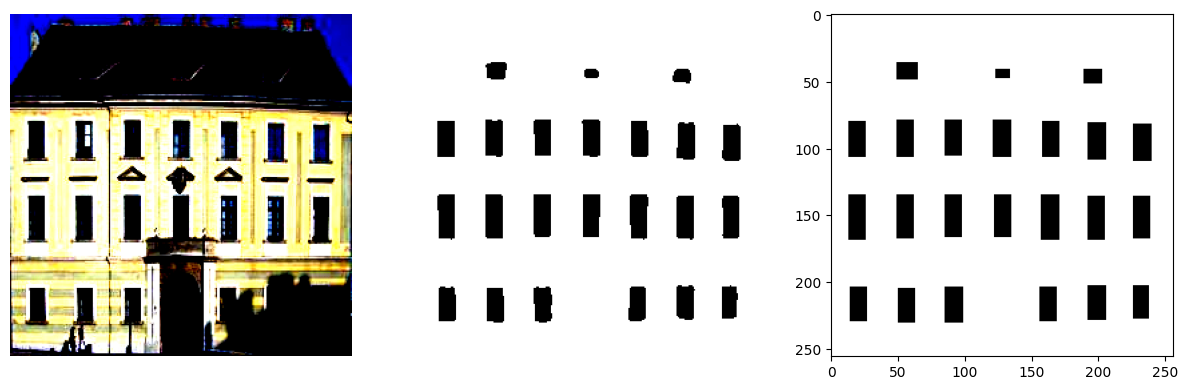

In [122]:
#
#    Обработем изображение
#
#  1) Вывод количества окон на изображении
#  2) Само изображение
#  3) сгенерированное изображение маски
#  4) улучшенное изображение полученной маски
#
#
#   num - Номер в тестовом датасете
#

num = 6
segmenation_fasads(num)

Количество окон:  23


Этажей:  6


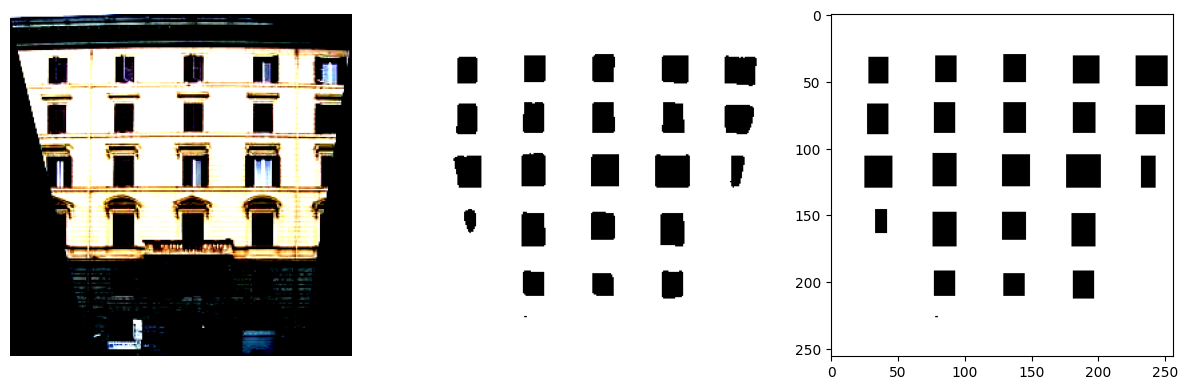

In [123]:
#
#   
#

num = 2
segmenation_fasads(num)

In [106]:
'''

import gc
del valid_epoch
gc.collect()   
del train_epoch
del train_loader
del valid_loader
del train_dataset
gc.collect()   

'''

'\n\nimport gc\ndel valid_epoch\ngc.collect()   \ndel train_epoch\ndel train_loader\ndel valid_loader\ndel train_dataset\ngc.collect()   \n\n'

In [107]:
# torch.cuda.empty_cache()  